<a href="https://colab.research.google.com/github/EnricoHuber/POS-Tagging-Classification/blob/main/NLP_Project_POS_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import requests
import string
import pickle
import os

import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from google.colab import drive

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [58]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
filepath = '/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/Datasets/italian_training_10000.utf8'

In [60]:
def get_num_lines(filepath):
  with open(filepath) as my_file:
    return sum(1 for _ in my_file)

In [61]:
file_lines = get_num_lines(filepath)
file_lines

10000

In [62]:
def get_sentences(line_length, filepath, language):
  tokens = []
  if language == 'eng':
    tag_column = 2
  elif language == 'ita':
    tag_column = 3
  sentences = []
  with open(filepath, 'r') as file:
    """preprocessing"""
    sentence = []
    for line in file:
      line = str.split(str.strip(line))
      if len(line) == line_length:
        token, pos_tag = line[0], line[tag_column]
        tokens.append(token)
        sentence.append((token, pos_tag))
        continue
      sentences.append(sentence)
      sentence = []
    return sentences, tokens

In [63]:
corpus, tokens = get_sentences(7, filepath, 'ita')    # Use 'eng' instead of 'ita' and 3 instead of 7 for using the english corpus

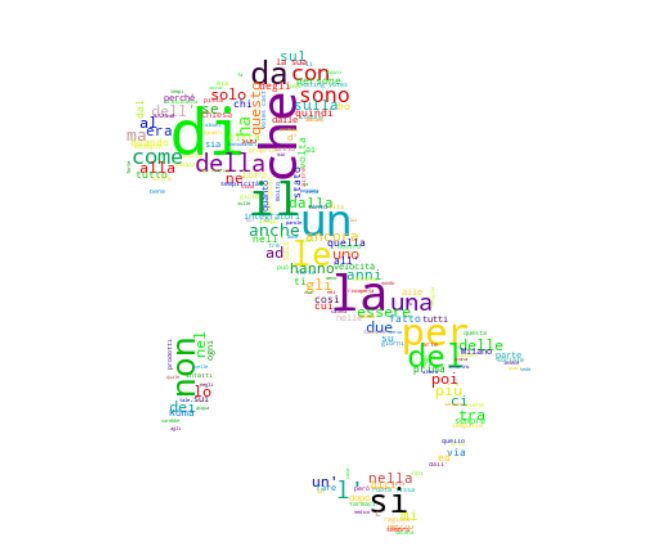

In [64]:
stopwords = set(STOPWORDS)

italy_mask = np.array(Image.open('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/Italia.png'))
wordcloud = WordCloud(width=2000, height=1200, colormap='nipy_spectral', background_color='white', margin=-2, stopwords=stopwords, mask=italy_mask).generate(' '.join(tokens))
plt.figure(figsize=((20, 10)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.savefig('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/WordCloud.png')
plt.show()

In [65]:
def remove_blanklines(corpus_raw):
  """
  Since our corpus had blank lines, we should remove them, otherwise we would have empty lists as sentences
  """
  corpus_clean = [x for x in corpus if x]
  return corpus_clean

In [66]:
corpus_clean = remove_blanklines(corpus)

In [67]:
# In order to check if we actually removed some lines. If False then yes, we did it!
len(corpus_clean) is len(corpus)

False

In [68]:
def corpus_train_test_split(corpus, split=0.8):
  random.shuffle(corpus)
  step = len(corpus)*split
  corpus_train, corpus_test = corpus[:int(step)], corpus[int(step):]
  return corpus_train, corpus_test

In [69]:
corpus_train, corpus_test = corpus_train_test_split(corpus_clean)

In [70]:
len(corpus_train), len(corpus_test), len(corpus_clean), (len(corpus_train) + len(corpus_test) is len(corpus_clean))

(305, 77, 382, False)

In [71]:
def get_features(token, token_index, sentence):
  token_feature = {
      'token'                     : token,
      'is_first'                  : token_index == 0,
      'is_last'                   : token_index == len(sentence) - 1,
      'is_capitalized'            : token[0].upper() == token[0],
      'is_all_capitalized'        : token.upper() == token,
      'is_capitals_inside'        : token[1:].lower() != token[1:],

      'prefix-1'                  : token[0],
      'prefix-2'                  : '' if len(token) < 2 else token[:2],
      'prefix-3'                  : '' if len(token) < 3 else token[:3],
      'prefix-4'                  : '' if len(token) < 4 else token[:4],
      'prefix-5'                  : '' if len(token) < 5 else token[:5],

      'suffix-1'                  : token[len(token)-1],
      'suffix-2'                  : '' if len(token) < 2 else token[-2:],
      'suffix-3'                  : '' if len(token) < 3 else token[-3:],
      'suffix-4'                  : '' if len(token) < 4 else token[-4:],
      'suffix-5'                  : '' if len(token) < 5 else token[-5:],

      'has-digits'                : True if [True for char in token if char in string.digits] else False,
      
      'prev-token'                : '' if token_index == 0 else sentence[token_index - 1][0],
      '2-prev-token'              : '' if token_index <= 1 else sentence[token_index - 2][0],
      'prev-token-samelast'       : False if token_index == 0 or sentence[token_index - 1][0][-1].lower() != token[-1].lower() else True,
      'succ-token-samelast'       : False if token_index == len(sentence)-1 or sentence[token_index + 1][0][-1].lower() != token[-1].lower() else True,

      'next-token'                : '' if token_index == len(sentence) - 1 else sentence[token_index + 1][0],
      '2-next-token'              : '' if token_index >= len(sentence) - 2 else sentence[token_index + 2][0]
  }
  return token_feature

In [72]:
def extract_features(all_sentences):
    features   = []                                                     # This is our x_train
    pos_labels = []                                                     # This is our y_train
    for sentence in all_sentences:
        for token_index, token_pair in enumerate(sentence):
            token       = token_pair[0]                                 # Get token
            features.append(get_features(token, token_index, sentence)) # Extract features from token and append it to features list (x_train)
            pos_label = token_pair[1]                                   # Get ground truth (golden) pos label of token
            pos_labels.append(pos_label)                                # Append pos label to pos_labels list (y_train) 

    return features, pos_labels    

In [73]:
features_train, pos_labels_train = extract_features(corpus_train)

In [74]:
features_test, pos_labels_test = extract_features(corpus_test)

In [75]:
def tag_occurencies(tag_list):
  tag_dict = {}
  for tag in tag_list:
    if tag not in tag_dict:
      tag_dict[tag] = 1
    else:
      tag_dict[tag] += 1
  return tag_dict

In [76]:
np.unique(pos_labels_train), len(list(np.unique(pos_labels_train)))

(array(['A', 'AP', 'B', 'BN', 'CC', 'CS', 'DD', 'DI', 'DQ', 'E', 'EA',
        'FB', 'FC', 'FF', 'FS', 'I', 'N', 'NO', 'PC', 'PD', 'PE', 'PI',
        'PP', 'PQ', 'PR', 'RD', 'RI', 'S', 'SA', 'SP', 'SW', 'T', 'V',
        'VA', 'VM', 'X'], dtype='<U2'), 36)

In [77]:
tag_occurencies(pos_labels_train)

{'A': 496,
 'AP': 58,
 'B': 380,
 'BN': 73,
 'CC': 262,
 'CS': 91,
 'DD': 34,
 'DI': 34,
 'DQ': 3,
 'E': 749,
 'EA': 454,
 'FB': 224,
 'FC': 49,
 'FF': 364,
 'FS': 295,
 'I': 2,
 'N': 133,
 'NO': 14,
 'PC': 158,
 'PD': 31,
 'PE': 30,
 'PI': 46,
 'PP': 2,
 'PQ': 1,
 'PR': 132,
 'RD': 439,
 'RI': 168,
 'S': 1569,
 'SA': 7,
 'SP': 353,
 'SW': 87,
 'T': 9,
 'V': 846,
 'VA': 137,
 'VM': 38,
 'X': 5}

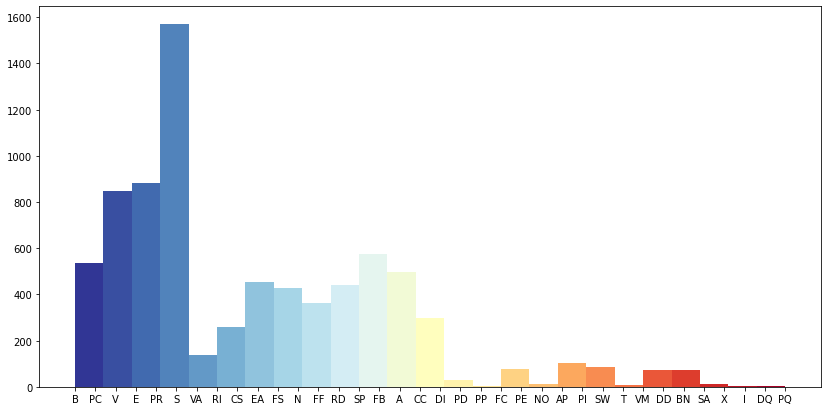

In [78]:
# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=((14, 7)))
# Plot histogram.
n, bins, patches = plt.hist(pos_labels_train, 25, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.savefig('/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/POS_LabelsHist.png')
plt.show()

### Preparing the Data

In [79]:
t0 = time.time()
vectorizer = DictVectorizer(sparse=True)
data_vect = vectorizer.fit_transform(features_train)
print(f'Vectorization elapsed in {time.time() - t0:.2f} s')

Vectorization elapsed in 0.26 s


In [80]:
data_vect, data_vect.shape

(<7773x21855 sparse matrix of type '<class 'numpy.float64'>'
 	with 178779 stored elements in Compressed Sparse Row format>, (7773, 21855))

### Training and Evaluating the models

In [81]:
scores = {}
computational_costs = {}
fold = 5

In [82]:
def fit_save_models(model, model_name, X, y, file_lines):
  model_path='/content/drive/MyDrive/NLP/PROGETTO INTERCORSO/Models'
  model.fit(X, y)
  model_pickle = os.path.join(model_path, model_name + str(file_lines) + '.pkl')
  with open(model_pickle, 'wb') as file:
    pickle.dump(model, file)

In [83]:
model_name = 'LogisticRegression'
lr = LogisticRegression(solver='liblinear')
t0 = time.time()
score_log = scores[model_name] = np.mean(cross_val_score(lr, data_vect, pos_labels_train, scoring='accuracy', cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_log}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished

Training/Testing of LogisticRegression with 5 fold done in 8.01 s	|	Score is 0.8710913026025567


In [84]:
model_name = 'SVM_OvR'
ovr_clf = OneVsRestClassifier(SVC())
t0 = time.time()
score_ovr_clf = scores[model_name] = np.mean(cross_val_score(ovr_clf, data_vect, pos_labels_train, scoring='accuracy', cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_ovr_clf}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.3min remaining:   53.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished

Training/Testing of SVM_OvR with 5 fold done in 106.38 s	|	Score is 0.8592559394488655


In [85]:
model_name = 'SVM'
svm_clf = SVC()
t0 = time.time()
score_svm_clf = scores[model_name] = np.mean(cross_val_score(svm_clf, data_vect, pos_labels_train, scoring='accuracy', cv=fold, verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_svm_clf}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.9s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished

Training/Testing of SVM with 5 fold done in 43.74 s	|	Score is 0.8350699160345464


In [86]:
model_name = 'RandomForest'
rf = RandomForestClassifier()
t0 = time.time()
score_rf = scores[model_name] = np.mean(cross_val_score(rf, data_vect, pos_labels_train, cv=fold, scoring='accuracy', verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_rf}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   37.7s remaining:   25.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.4s finished

Training/Testing of RandomForest with 5 fold done in 49.56 s	|	Score is 0.8443331802174245


In [87]:
model_name = 'MultiLayerPerceptron'
mlp = MLPClassifier()
t0 = time.time()
score_mlp = scores[model_name] = np.mean(cross_val_score(mlp, data_vect, pos_labels_train, cv=fold, scoring='accuracy', verbose=100, n_jobs=-1))
comput_time = (time.time()-t0)
computational_costs[model_name] = comput_time
print('\n' + f'Training/Testing of {model_name} with {fold} fold done in {comput_time:.2f} s', f'Score is {score_mlp}', sep = '\t|\t')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.1min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min finished

Training/Testing of MultiLayerPerceptron with 5 fold done in 403.09 s	|	Score is 0.8725062591300533


Now we pass the models to the fit_save function we created above. This will fit all our models on the entire training set and save each model with *pickle*

In [88]:
models = {
    lr      : 'LogisticRegression',
    ovr_clf : 'SVM_OvR',
    svm_clf : 'SVM',
    rf      : 'RandomForest',
    mlp     : 'MultiLayerPerceptron'
}

for model, model_name in models.items():
  fit_save_models(model, model_name, data_vect, pos_labels_train, file_lines)

In [89]:
scores

{'LogisticRegression': 0.8710913026025567,
 'MultiLayerPerceptron': 0.8725062591300533,
 'RandomForest': 0.8443331802174245,
 'SVM': 0.8350699160345464,
 'SVM_OvR': 0.8592559394488655}

In [137]:
def plot_trainsize_vs_score(trainsize, score, model, plotting='accuracy', width=2):
  plt.xlabel('Training Instance')
  if plotting == 'accuracy':
    plt.ylabel('Accuracy')
  elif plotting == 'costs':
    plt.ylabel('Computational cost (s)')
  if model == 'LogisticRegression':
    plt.plot(trainsize, score, color='red', linewidth=width, label=model)
  elif model == 'RandomForest':
    plt.plot(trainsize, score, color='blue', linewidth=width, label=model)
  elif model == 'SVM':
    plt.plot(trainsize, score, color='orange', linewidth=width, label=model)
  elif model == 'SVM_OvR':
    plt.plot(trainsize, score, color='black', linewidth=width, label=model)
  elif model == 'MultiLayerPerceptron':
    plt.plot(trainsize, score, color='green', linewidth=width, label=model)
  plt.legend()

In [34]:
score_vs_trainsize = {}

In [91]:
score_vs_trainsize[len(pos_labels_train)] = scores    # Score the training score of cross validation

In [92]:
score_vs_trainsize

{760: {'LogisticRegression': 0.7671052631578947,
  'MultiLayerPerceptron': 0.7657894736842106,
  'RandomForest': 0.7394736842105264,
  'SVM': 0.7171052631578947,
  'SVM_OvR': 0.7671052631578947},
 7773: {'LogisticRegression': 0.8710913026025567,
  'MultiLayerPerceptron': 0.8725062591300533,
  'RandomForest': 0.8443331802174245,
  'SVM': 0.8350699160345464,
  'SVM_OvR': 0.8592559394488655}}

In [93]:
len(score_vs_trainsize)

2

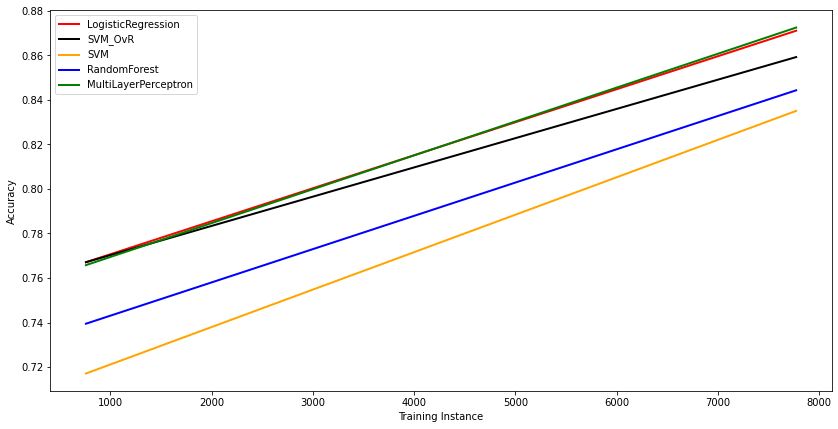

In [136]:
plt.figure(figsize=((14, 7)))
n_instances = []
scores = []
for _, model_name in models.items():
  for size, results in score_vs_trainsize.items():
    if size not in n_instances:
      n_instances.append(size)
    scores.append(results[model_name]) 
  plot_trainsize_vs_score(n_instances, scores, model_name)
  scores = []

plt.show()

In [139]:
cost_vs_trainsize = {}

In [141]:
cost_vs_trainsize[len(pos_labels_train)] = computational_costs

{7773: {'LogisticRegression': 8.00569200515747,
  'MultiLayerPerceptron': 403.09446358680725,
  'RandomForest': 49.55688714981079,
  'SVM': 43.74417281150818,
  'SVM_OvR': 106.3822271823883}}

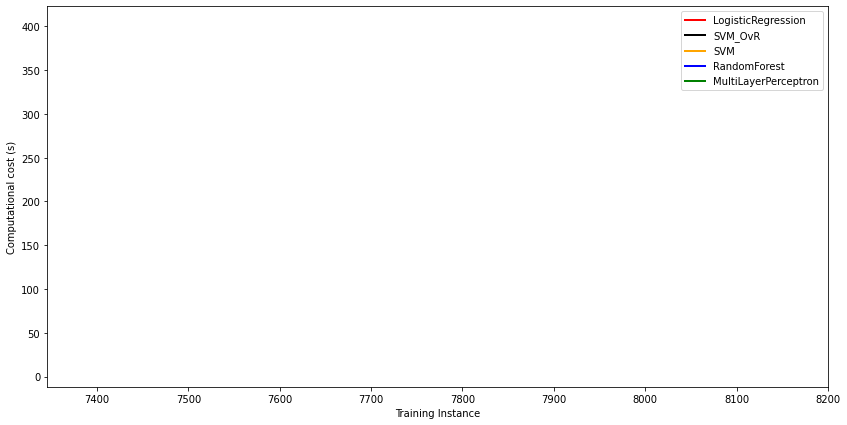

In [142]:
plt.figure(figsize=((14, 7)))
n_instances = []
scores = []
for _, model_name in models.items():
  for size, results in cost_vs_trainsize.items():
    if size not in n_instances:
      n_instances.append(size)
    scores.append(results[model_name]) 
  plot_trainsize_vs_score(n_instances, scores, model_name, plotting='costs')
  scores = []

plt.show()